In [1]:
import tensorflow as tf
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.layers import Dense, Embedding, Input, Add, Dot, Reshape, Flatten
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.sequence import skipgrams
from tensorflow.python.keras.models import Model, load_model
import sklearn
import array
import pickle
import tarfile
from urllib.request import urlretrieve
import os
import sys
from os import listdir
import nltk
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_distances
from os.path import isfile, join
from scipy.sparse import csr_matrix, lil_matrix
import numpy as np
from scipy.sparse import save_npz, load_npz
from tensorflow.python.keras import backend as K
import random
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
def getTextFromCooc(pathToFile):
    with open(pathToFile, 'r', encoding='utf8') as f:
        indexRow = 0
        headerText = []
        docs = []
        for row in f:
            if(indexRow == 0):
                for word in row.split(','):
                    headerText.append(word)
            else:
                indexNumber = 0
                isStringCreated = False
                for word2 in row.split(','):
                    if(indexNumber == 0):
                        pass
                    else:
                        if int(word2) == 1:
                            if(isStringCreated == False):
                                string = ''
                                isStringCreated = True
                            if(string == ""):
                                string = headerText[indexNumber-1]
                            else:
                                string = string +' '+headerText[indexNumber-1]
                    indexNumber += 1
                #string = string[2:]
                docs.append(string)
                docs = [s.replace("'", '"') for s in docs] # remove all the 8s 
            indexRow +=1
    with open('./docs/textTheGoodScents.txt','wb') as f:
        pickle.dump(docs, f)
    return [docs,headerText]

In [3]:
docs,headerText = getTextFromCooc('./TGS/dataTGS.csv')
#docs = [s.replace(" ", '') for s in docs]
docs = [s.replace('""', '" "') for s in docs]
headerText = headerText[1:]

In [7]:
def strip_first_col(fname, delimiter=','):
    with open(fname, 'r') as fin:
        for line in fin:
            try:
               yield line.split(delimiter, 1)[1]
            except IndexError:
               continue
array = np.loadtxt(strip_first_col('./TGS/dataTGS.csv'), delimiter=",", skiprows=1)
cooc_mat2 = np.dot(array.T,array)
print(cooc_mat2)

[[67.  0.  0. ...  0.  0.  0.]
 [ 0.  8.  0. ...  0.  0.  0.]
 [ 0.  0.  4. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... 28.  0.  0.]
 [ 0.  0.  0. ...  0.  2.  0.]
 [ 0.  0.  0. ...  0.  0. 40.]]


In [8]:
print(len(docs))
docs = docs[:2500]
print(len(docs))

4573
2500


In [4]:
v_size = len(headerText)
tokenizer = Tokenizer(num_words=v_size, oov_token='UNK')
tokenizer.fit_on_texts(docs)

In [5]:
generate_cooc = False
def generate_cooc_matrix(text, tokenizer, window_size, n_vocab, use_weighting=True):
    sequences = tokenizer.texts_to_sequences(text)
    meanLen = 0
    meanNumber = 0
    print(sequences)
    for sequence in sequences:
        meanLen += len(sequence)
        meanNumber +=1
    meanLen = meanLen/meanNumber
    window_size = round(meanLen)
    cooc_mat = lil_matrix((n_vocab, n_vocab), dtype=np.float32)
    for sequence in sequences:
        window_size = int(len(sequence)/2)
        if(len(sequence) % 2 == 0):
            for i, wi in zip(np.arange(window_size, len(sequence)-window_size+1), sequence[window_size-1:-window_size]):
                context_window = sequence[i-window_size: i+window_size+1]
                distances = np.abs(np.arange(-(window_size-1), window_size+1))
                distances[window_size] = 1.0
                nom = np.ones(shape=(window_size*2,), dtype=np.float32)
                nom[window_size-1] = 0.0
                if use_weighting:
                    cooc_mat[wi, context_window] += nom/distances    # Update element
                else:
                    for y in range(0,len(sequence)-1):
                        nom = np.ones(shape=(window_size*2,), dtype=np.float32)
                        nom[y] = 0.0
                        cooc_mat[sequence[y], context_window] += nom
        else:
            for i, wi in zip(np.arange(window_size, len(sequence)-window_size), sequence[window_size:-window_size]):
                context_window = sequence[i-window_size: i+window_size+1]
                distances = np.abs(np.arange(-window_size, window_size+1))
                distances[window_size] = 1.0
                nom = np.ones(shape=(window_size*2 + 1,), dtype=np.float32)
                nom[window_size] = 0.0
                if use_weighting:
                    cooc_mat[wi, context_window] += nom/distances    # Update element
                else:
                    for y in range(0,len(sequence)-1):
                        nom = np.ones(shape=(window_size*2 + 1,), dtype=np.float32)
                        nom[y] = 0.0
                        cooc_mat[sequence[y], context_window] += nom
    return cooc_mat    

if not generate_cooc:
    cooc_mat = generate_cooc_matrix(docs, tokenizer, 4, v_size, False)
    print("Generated......")
    cooc_mat
    save_npz(os.path.join('datasets','cooc_mat.npz'), cooc_mat.tocsr())
else:
    cooc_mat = load_npz(os.path.join('datasets','cooc_mat.npz')).tolil()
    print('Cooc matrix of type {} was loaded from disk'.format(type(cooc_mat).__name__))
    
print(cooc_mat)

[[106, 132, 13, 249, 62, 4, 229, 2, 20, 40], [53], [82, 13, 250, 5, 117], [82, 13, 250, 5, 117], [82, 13, 62, 99, 4, 5, 2, 26, 14], [82, 6, 249, 62, 4, 15, 2, 17, 20, 202], [48, 39, 113, 22, 36, 251, 142, 28, 118, 3], [280, 238, 94, 250, 41, 117], [6, 39, 8, 230, 125], [7], [7], [5, 17, 67, 126, 26, 190, 14, 3], [33, 6, 68], [203, 11, 138], [148, 107, 186, 5, 119, 14, 3, 57, 104], [13, 8, 2, 187, 43], [13, 9, 4, 15, 10, 17, 40], [21, 4, 7, 3], [48, 83, 50, 39, 317, 102, 18, 36, 281, 3], [48, 56, 99], [39], [39], [4, 5, 2, 31, 231, 20, 3], [106, 8, 5], [69, 5, 46, 71], [12, 37, 4, 2, 17, 24, 54, 125, 16], [12, 37, 4, 2, 17, 24, 54, 125, 16], [238, 25, 13, 81, 102, 4, 8, 2, 142, 63], [79, 5, 3], [2, 71], [2, 71], [74, 2, 23, 43], [12, 9, 5, 2, 76, 14, 3], [9, 186, 2, 10, 17, 55, 3], [97], [42, 2, 23, 143], [9, 4, 11, 100, 2, 38, 23, 3], [37, 6, 9, 8, 11, 2, 23, 3], [69, 4, 5, 2, 54], [297, 239, 240, 58, 44], [46, 103, 3], [53, 106, 132, 22, 16], [55], [55], [135], [21, 9, 8, 5, 11, 2, 7,

Generated......
  (1, 2)	1.0
  (1, 8)	1.0
  (1, 9)	1.0
  (1, 11)	1.0
  (1, 12)	1.0
  (1, 28)	1.0
  (1, 36)	1.0
  (1, 48)	1.0
  (1, 71)	1.0
  (1, 81)	1.0
  (1, 83)	1.0
  (1, 88)	1.0
  (1, 109)	1.0
  (1, 120)	1.0
  (1, 135)	1.0
  (1, 183)	1.0
  (1, 200)	1.0
  (1, 251)	1.0
  (2, 1)	1.0
  (2, 3)	466.0
  (2, 4)	426.0
  (2, 5)	266.0
  (2, 6)	146.0
  (2, 7)	184.0
  (2, 8)	130.0
  (2, 9)	210.0
  (2, 10)	161.0
  (2, 11)	119.0
  (2, 12)	115.0
  (2, 13)	77.0
  (2, 14)	99.0
  (2, 15)	55.0
  (2, 16)	58.0
  (2, 17)	103.0
  (2, 18)	79.0
  (2, 19)	88.0
  (2, 20)	74.0
  (2, 21)	136.0
  (2, 22)	37.0
  (2, 23)	152.0
  (2, 24)	59.0
  (2, 25)	116.0
  (2, 26)	35.0
  (2, 27)	17.0
  (2, 28)	26.0
  (2, 29)	36.0
  (2, 30)	40.0
  (2, 31)	58.0
  (2, 32)	70.0
  (2, 33)	15.0
  (2, 34)	69.0
  (2, 35)	38.0
  (2, 36)	18.0
  (2, 37)	90.0
  (2, 38)	84.0
  (2, 39)	12.0
  (2, 40)	30.0
  (2, 41)	73.0
  (2, 42)	45.0
  (2, 43)	72.0
  (2, 44)	22.0
  (2, 45)	39.0
  (2, 46)	38.0
  (2, 47)	37.0
  (2, 48)	7.0
  (2, 49)	42.0
  (2,

# TSNE SUR DONNEES BRUTES

[1.0, 1.0, 1.0, 1.0]
[0.5171427, 0.5177572, 0.5287088, 0.53890586]
[0.15979737, 0.16790116, 0.16790515, 0.17012793]
[0.18399096, 0.21257597, 0.240524, 0.2421565]
[0.14194995, 0.14751834, 0.15160012, 0.154059]
[0.13416803, 0.14362109, 0.14809906, 0.15223056]
[0.15340644, 0.15436083, 0.16385013, 0.16447389]
[0.0960294, 0.14809906, 0.15279037, 0.1622755]
[0.12723845, 0.13230675, 0.14362109, 0.14551449]
[0.104682624, 0.14078647, 0.14328909, 0.14492786]
[0.12910211, 0.13804448, 0.14558673, 0.17102134]
[0.0960294, 0.109749615, 0.11788815, 0.13230675]
[0.10337502, 0.109749615, 0.123107016, 0.1243121]
[0.11756587, 0.12260181, 0.15002358, 0.15539265]
[0.102828264, 0.123107016, 0.12550485, 0.13776582]
[0.18528485, 0.23353142, 0.23422831, 0.25135475]
[0.10690242, 0.11775851, 0.11901039, 0.14212489]
[0.09937847, 0.104682624, 0.107367456, 0.12150413]
[0.09709358, 0.10690242, 0.14671642, 0.15232712]
[0.17279577, 0.18547046, 0.19600207, 0.19785196]
[0.11756587, 0.12597227, 0.16620266, 0.17268944]
[0.

[t-SNE] Computed conditional probabilities for sample 380 / 380
[t-SNE] Mean sigma: 0.195294
[t-SNE] Computed conditional probabilities in 0.020s
[t-SNE] Iteration 50: error = 60.7541809, gradient norm = 0.0000001 (50 iterations in 0.125s)
[t-SNE] Iteration 50: gradient norm 0.000000. Finished.
[t-SNE] KL divergence after 50 iterations with early exaggeration: 60.754181
[t-SNE] Iteration 100: error = 1.4043553, gradient norm = 0.0124915 (50 iterations in 0.115s)
[t-SNE] Iteration 150: error = 1.0293846, gradient norm = 0.0026256 (50 iterations in 0.149s)
[t-SNE] Iteration 200: error = 0.9421464, gradient norm = 0.0011732 (50 iterations in 0.162s)
[t-SNE] Iteration 250: error = 0.9094286, gradient norm = 0.0006948 (50 iterations in 0.154s)
[t-SNE] Iteration 300: error = 0.8942733, gradient norm = 0.0012083 (50 iterations in 0.142s)
[t-SNE] Iteration 350: error = 0.8868533, gradient norm = 0.0003466 (50 iterations in 0.138s)
[t-SNE] Iteration 400: error = 0.8833610, gradient norm = 0.000

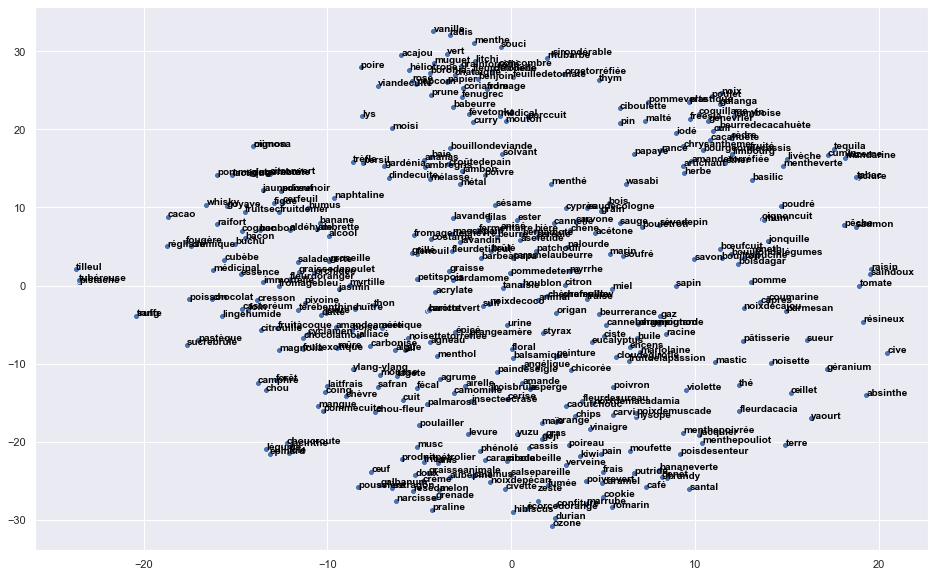

In [9]:
# calculer matrice et enlever diagonale (val à 0) trier chaque ligne en décroissant 
# et prendr les 4 premiers (vérifier si il y a des voisins lus proche > 1)
# a faire sur donnée centrée 
# -------------- DONE --------------
# regarder sur les données d'Oniris
# -------------- DONE --------------
# refaire 8-9 visu pr tsne avec données brutes (centré) en faisant varié les params 
# faire un cosinus sur les 150 premieres dimensions de l'ACP (prendre les n dimensions représentant 90% de l'info + faire tsn-e sur cette matrice)
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 10)

cooc_mat_cosine = cosine_distances(cooc_mat)

for row in cooc_mat_cosine:
    t = np.array(row)
    indices = t.argsort()
    indices = indices[t[indices] > 0]
    print([t[indices[0]],t[indices[1]],t[indices[2]],t[indices[3]]])

tsne = TSNE(n_components=2,metric='precomputed',verbose=2,n_iter=2000,perplexity=20,early_exaggeration = 12,learning_rate=10)
X_embedded = tsne.fit_transform(cooc_mat_cosine)


df_subset = {} 
df_subset['tsne-2d-one'] = X_embedded[:,0]
df_subset['tsne-2d-two'] = X_embedded[:,1]
plt.figure(figsize=(16,10))
p1 = sns.scatterplot(X_embedded[:,0], X_embedded[:,1], legend='full', palette=palette)
for line in range(0,cooc_mat.shape[0]):
     p1.text(df_subset['tsne-2d-one'][line]+0.01, df_subset['tsne-2d-two'][line], 
     headerText[line], horizontalalignment='left', 
     size='small', color='black', weight='semibold')

# TSNE SUR DONNEES BRUTES CENTREE REDUITE

[1.0, 1.0, 1.0, 1.0]
[0.37409526, 0.49111634, 0.6319648, 0.66244006]
[0.23722124, 0.35936528, 0.37472785, 0.3818007]
[0.44369394, 0.48853475, 0.49619538, 0.522161]
[0.23722124, 0.3304742, 0.3527851, 0.37538958]
[0.3527851, 0.38090402, 0.38819242, 0.41964757]
[0.27054584, 0.3076542, 0.36021495, 0.37538958]
[0.3076542, 0.32134485, 0.37613356, 0.38924825]
[0.27054584, 0.32134485, 0.3304742, 0.40916884]
[0.27793694, 0.3308177, 0.37472785, 0.37869328]
[0.27793694, 0.34993994, 0.47540212, 0.48379672]
[0.38924825, 0.431974, 0.43503797, 0.44421118]
[0.39931178, 0.40180147, 0.46291107, 0.46945477]
[0.36021495, 0.40916884, 0.42983627, 0.4897861]
[0.38090402, 0.4777317, 0.49549586, 0.5421256]
[0.3274095, 0.37334484, 0.3879773, 0.42227542]
[0.45677215, 0.46058124, 0.47271812, 0.49531114]
[0.3308177, 0.34993994, 0.48816848, 0.49977392]
[0.40539098, 0.40906888, 0.43187076, 0.43860668]
[0.44959587, 0.46381038, 0.46893376, 0.4808361]
[0.3845517, 0.4798463, 0.4897861, 0.49433547]
[0.3818007, 0.47379863

[t-SNE] Iteration 50: error = 61.9324226, gradient norm = 0.0000000 (50 iterations in 0.179s)
[t-SNE] Iteration 50: gradient norm 0.000000. Finished.
[t-SNE] KL divergence after 50 iterations with early exaggeration: 61.932423
[t-SNE] Iteration 100: error = 1.6474966, gradient norm = 0.0105947 (50 iterations in 0.140s)
[t-SNE] Iteration 150: error = 1.2010595, gradient norm = 0.0021810 (50 iterations in 0.122s)
[t-SNE] Iteration 200: error = 1.1230409, gradient norm = 0.0009664 (50 iterations in 0.121s)
[t-SNE] Iteration 250: error = 1.0903844, gradient norm = 0.0005421 (50 iterations in 0.122s)
[t-SNE] Iteration 300: error = 1.0744905, gradient norm = 0.0004008 (50 iterations in 0.118s)
[t-SNE] Iteration 350: error = 1.0652835, gradient norm = 0.0002973 (50 iterations in 0.124s)
[t-SNE] Iteration 400: error = 1.0598544, gradient norm = 0.0002601 (50 iterations in 0.123s)
[t-SNE] Iteration 450: error = 1.0568528, gradient norm = 0.0002144 (50 iterations in 0.126s)
[t-SNE] Iteration 500

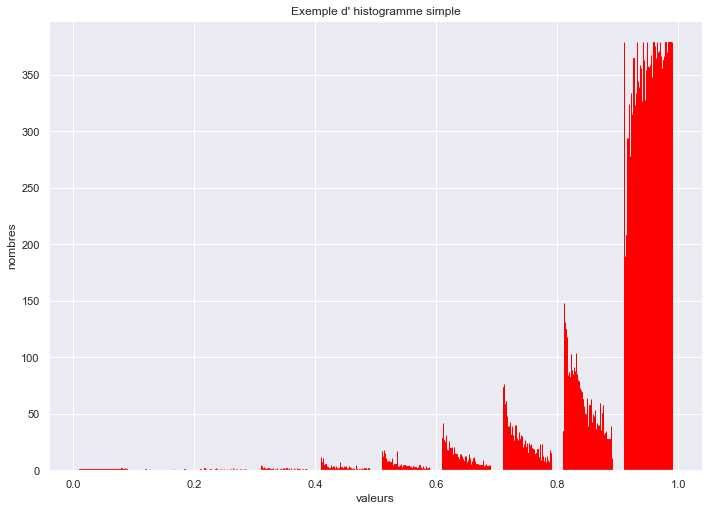

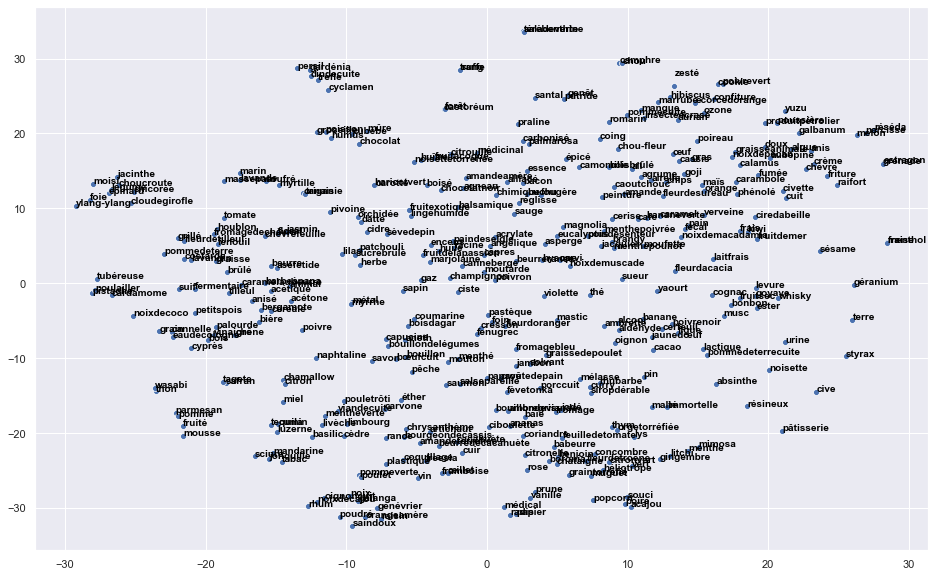

In [16]:
#faire distribution sur 4ppv avec histogramme données brutes
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
Z = sc.fit_transform(cooc_mat)

sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 10)

cooc_mat_cosine = cosine_distances(Z)
# augmenter le pas
plt.hist(cooc_mat_cosine,
            edgecolor = 'red')
plt.xlabel('valeurs')
plt.ylabel('nombres')
plt.title('Exemple d\' histogramme simple')

for row in cooc_mat_cosine:
    t = np.array(row)
    indices = t.argsort()
    indices = indices[t[indices] > 0]
    print([t[indices[0]],t[indices[1]],t[indices[2]],t[indices[3]]])

tsne = TSNE(n_components=2,metric='cosine',verbose=2,n_iter=2000,perplexity=20,early_exaggeration = 12,learning_rate=10)
X_embedded = tsne.fit_transform(Z.toarray())
df_subset = {} 
df_subset['tsne-2d-one'] = X_embedded[:,0]
df_subset['tsne-2d-two'] = X_embedded[:,1]
plt.figure(figsize=(16,10))

p1 = sns.scatterplot(X_embedded[:,0], X_embedded[:,1], legend='full', palette=palette)
for line in range(0,Z.shape[0]):
     p1.text(df_subset['tsne-2d-one'][line]+0.01, df_subset['tsne-2d-two'][line], 
     headerText[line], horizontalalignment='left', 
     size='small', color='black', weight='semibold')

  (0, 2)	1.0
  (0, 3)	4.0
  (0, 4)	1.0
  (0, 5)	3.0
  (0, 8)	7.0
  (0, 9)	12.0
  (0, 10)	1.0
  (0, 11)	1.0
  (0, 12)	2.0
  (0, 13)	4.0
  (0, 15)	6.0
  (0, 16)	1.0
  (0, 17)	6.0
  (0, 18)	1.0
  (0, 25)	4.0
  (0, 27)	4.0
  (0, 30)	1.0
  (0, 31)	2.0
  (0, 32)	2.0
  (0, 39)	1.0
  (0, 40)	3.0
  (0, 41)	1.0
  (0, 54)	2.0
  (0, 56)	1.0
  (0, 57)	1.0
  :	:
  (0, 93)	2.0
  (0, 96)	1.0
  (0, 99)	1.0
  (0, 102)	6.0
  (0, 107)	1.0
  (0, 125)	1.0
  (0, 130)	2.0
  (0, 133)	1.0
  (0, 134)	1.0
  (0, 135)	2.0
  (0, 150)	1.0
  (0, 153)	1.0
  (0, 155)	1.0
  (0, 156)	1.0
  (0, 162)	1.0
  (0, 171)	5.0
  (0, 179)	1.0
  (0, 189)	1.0
  (0, 201)	1.0
  (0, 204)	2.0
  (0, 228)	1.0
  (0, 232)	1.0
  (0, 274)	1.0
  (0, 276)	1.0
  (0, 344)	1.0
2
[[  0.   0.   0. 311. 270. 174. 114.  80. 156. 109.  75.  74.  72.  77.
   41.  67.  26.  56.  55.  47.  42.  35. 112.  81.  84.  16.  15.  13.
   40.  26.  17.  21.  45.  23.  59.   8.  60.  51.   6.   6.   8.  33.
   20.  42.  49.  25.  24.   9.  12.  11.  26.  25.  32.  1

([<matplotlib.axis.XTick at 0x232cbd73978>,
 <a list of 25 Text xticklabel objects>)

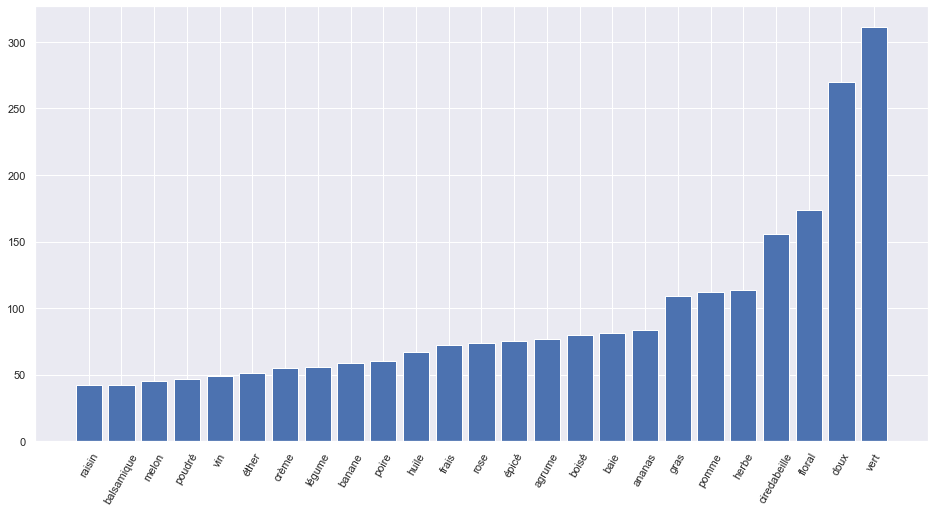

In [69]:
word="fruité"
assert word in tokenizer.word_index, 'Word {} is not in the tokenizer'.format(word)
assert tokenizer.word_index[word] <= v_size, 'The word {} is an out of vocabuary word. Please try something else'.format(word)

rev_word_index = dict(zip(tokenizer.word_index.values(), tokenizer.word_index.keys()))

#cooc_vec = np.array(cooc_mat.getrow(tokenizer.word_index[word]).todense()).ravel()
cooc_vec = np.array(cooc_mat.getrow(tokenizer.word_index[word]).todense()).ravel()

print(cooc_mat.getrow(122))
print(tokenizer.word_index[word])

print(cooc_mat.getrow(tokenizer.word_index[word]).todense())
max_ind = np.argsort(cooc_vec)[-25:]
print(max_ind)
plt.figure(figsize=(16,8))
print(cooc_vec)
plt.bar(np.arange(0, 25), cooc_vec[max_ind])
plt.xticks(ticks=np.arange(0, 25), labels=[rev_word_index[i] for i in max_ind], rotation=60)

In [6]:
def create_glove_model(v_size,emb_size =45):    
    w_i = Input(shape=(1,))
    w_j = Input(shape=(1,))

    emb_i = Flatten()(Embedding(v_size, emb_size, input_length=1)(w_i))
    emb_j = Flatten()(Embedding(v_size, emb_size, input_length=1)(w_j))

    ij_dot = Dot(axes=-1)([emb_i,emb_j])
    
    b_i = Flatten()(
        Embedding(v_size, 1, input_length=1)(w_i)
    )
    b_j = Flatten()(
        Embedding(v_size, 1, input_length=1)(w_j)
    )

    pred = Add()([ij_dot, b_i, b_j])

    def glove_loss(y_true, y_pred):
        return K.sum(
            K.pow((y_true-1)/100.0, 0.75)*K.square(y_pred - K.log(y_true))
        )

    model = Model(inputs=[w_i, w_j],outputs=pred)
    model.compile(loss=glove_loss, optimizer =Adam(lr=0.0001))
    return model

In [21]:
K.clear_session()
model = create_glove_model(v_size)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 45)        17100       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 45)        17100       input_2[0][0]                    
______________________________________________________________________________________________

In [22]:
cooc_mat = load_npz(os.path.join('datasets','cooc_mat.npz'))
print(cooc_mat.shape)
batch_size = 256
copy_docs = list(docs)
index2word = dict(zip(tokenizer.word_index.values(), tokenizer.word_index.keys()))
""" Each epoch """
for ep in range(15):
    
    #valid_words = get_valid_words(docs, 20, tokenizer)
    
    random.shuffle(copy_docs)
    losses = []
    """ Each document (i.e. movie plot) """
    for doc in copy_docs:
        
        seq = tokenizer.texts_to_sequences([doc])[0]

        """ Getting skip-gram data """
        # Negative samples are automatically sampled by tf loss function
        wpairs, labels = skipgrams(
            sequence=seq, vocabulary_size=v_size, negative_samples=0.0, shuffle=True
        )
        
        if len(wpairs)==0:
            continue

        sg_in, sg_out = zip(*wpairs)
        sg_in, sg_out = np.array(sg_in).reshape(-1,1), np.array(sg_out).reshape(-1,1)
        x_ij = np.array(cooc_mat[sg_in[:,0], sg_out[:,0]]).reshape(-1,1) + 1
        
        assert np.all(np.array(labels)==1)
        assert x_ij.shape[0] == sg_in.shape[0], 'X_ij {} shape does not sg_in {}'.format(x_ij.shape, sg_in.shape)
        """ For each batch in the dataset """
        model.fit([sg_in, sg_out], x_ij, batch_size = batch_size, epochs=1, verbose=0)
        l = model.evaluate([sg_in, sg_out], x_ij, batch_size=batch_size, verbose=0)
        losses.append(l)
    print('Loss in epoch {}: {}'.format(ep, np.mean(losses)))

(380, 380)
Loss in epoch 0: 190.8452267410661
Loss in epoch 1: 70.61001313341166
Loss in epoch 2: 12.031934221725615
Loss in epoch 3: 3.5467512998932302
Loss in epoch 4: 1.7880259082550074
Loss in epoch 5: 1.3293460906672874
Loss in epoch 6: 1.1309420904525396
Loss in epoch 7: 0.9993889202475076
Loss in epoch 8: 0.892917755641537
Loss in epoch 9: 0.7927381066341176
Loss in epoch 10: 0.6927620666186174
Loss in epoch 11: 0.5956944139310488
Loss in epoch 12: 0.5060857227243022
Loss in epoch 13: 0.42882577786935727
Loss in epoch 14: 0.36417965497951965


In [7]:
def save_embeddings(model,save_dir, tok, v_size):
    """ Saving data to disk """
    
    # We need to add the 0th index to word list manually
    word_list = ["RESERVED"]+[tok.index_word[w_i] for w_i in range(1,v_size)]
    emb_w_df = None
    for layer in model.layers:
        if 'embedding' == layer.name or 'embedding_1' == layer.name:
            if emb_w_df is None:
                emb_w_df = pd.DataFrame(layer.get_weights()[0])
            else:
                emb_w_df += layer.get_weights()[0]
    
    emb_w_df.insert(0, "word", word_list)
            
    emb_w_df.to_csv(
        os.path.join(save_dir, 'TGSembeddings_w.csv'), index=False, header=None
    )
    
save_embeddings(model, 'datasets', tokenizer, v_size)
model.save('glove_model.h5')

NameError: name 'model' is not defined

In [8]:
from sklearn.metrics.pairwise import cosine_similarity
def get_valid_words(docs, size, tok):
    """ Get a random set of words to check the embeddings """
    np.random.seed(120)
    valid_docs = np.random.choice(docs, size=size//2)
    valid_words = []
    for doc in valid_docs:
        np.random.seed(100)
        words = np.random.choice(tok.texts_to_sequences([doc])[0],size=2)
        valid_words.extend(words)
        
    return valid_words
        
valid_words = get_valid_words(docs, 10, tokenizer)
def load_embeddings(filename):
    print('Loading the word embeddings from the disk')
    embed_df = pd.read_csv(filename, index_col=False, header=None)
    embed_df = embed_df.set_index(0)
    print('Embedding shape: {}'.format(embed_df.shape))
    embed_mat = embed_df.values
    words = embed_df.index.values
    return embed_mat, words

def get_cosine_sim(emb, valid_words, top_k):
    norm = np.sqrt(np.sum(emb**2,axis=1,keepdims=True))
    norm_emb = emb/norm
    in_emb = norm_emb[valid_words,:]
    similarity = np.dot(in_emb, np.transpose(norm_emb))
    sorted_ind = np.argsort(-similarity, axis=1)[:,1:top_k+1]
    print(sorted_ind)
    return sorted_ind, valid_words

embed_mat, words = load_embeddings(os.path.join('datasets','TGSembeddings_w.csv'))
print(embed_mat)

print(words)
best_ids, wids = get_cosine_sim(embed_mat, valid_words, 5)
pd.Series(words).to_csv(os.path.join('datasets','index2word.csv'))
for w, bi in zip(wids, best_ids):
    print("{}: {}".format(words[w], ', '.join(words[bii] for bii in bi)))
    print("Classement des similaritées cosine :")
    for b in bi:
        print(cosine_similarity([embed_mat[w]],[embed_mat[b]]))
    

Loading the word embeddings from the disk
Embedding shape: (380, 40)
[[-0.02998566 -0.0844292  -0.05302051 ...  0.01470093  0.05128444
  -0.0262911 ]
 [-0.10500663 -0.0753089   0.02994168 ... -0.05516733 -0.00603708
   0.03771351]
 [-0.698633   -0.9013039   0.8267454  ... -0.56032616 -0.9052665
   0.47077256]
 ...
 [-0.067847   -0.0929177   0.11937361 ... -0.10035972 -0.11360287
   0.06141248]
 [-0.09509563 -0.07164303  0.04768506 ... -0.021896   -0.02039359
   0.06054317]
 [-0.01877938 -0.05665398  0.00987714 ... -0.00801491 -0.08050852
   0.13611603]]
['RESERVED' 'UNK' 'fruité' 'vert' 'doux' 'floral' 'boisé' 'herbe' 'épicé'
 'ciredabeille' 'gras' 'frais' 'agrume' 'balsamique' 'rose' 'fruitàcoque'
 'terre' 'huile' 'légume' 'crème' 'poudré' 'baie' 'menthé' 'pomme' 'moisi'
 'ananas' 'phénolé' 'camphre' 'soufré' 'aldéhyde' 'métal' 'miel' 'melon'
 'ambregris' 'raisin' 'caramel' 'oignon' 'banane' 'poire' 'café' 'vanille'
 'éther' 'fromage' 'vin' 'tabac' 'noixdecoco' 'jasmin' 'savon' 'ail'


D:\IDE\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


DescribeResult(nobs=1520, minmax=(0.0029405152938378754, 0.8817044751727504), mean=0.05311294752636707, variance=0.006378937650239237, skewness=6.309749882970646, kurtosis=54.10272626614589)
0.8007821427181511
0.8486662617602043
0.8705002722799994
0.8776746533476326
0.08466371399517725
0.08473698890000891
0.08758094799311145
0.09143186698634742
0.009256402026135202
0.010114431812894509
0.012137501264024353
0.013392795761958731
0.02889778992535119
0.03025368243765314
0.03099716841104727
0.034023289579713234
0.012467804912285607
0.015431910456437214
0.01642968620755747
0.017123497291357537
0.0076223479520713955
0.016497728940599754
0.016774008914461902
0.020385129498539212
0.013681313926296568
0.014205599437324468
0.014531607900981403
0.016694158069353482
0.016236051039002608
0.017596975860312614
0.020184687278244406
0.02218949974308293
0.008772599577340112
0.01164641959421786
0.015247117528876863
0.016839163650648414
0.021196885058093917
0.022039723886595808
0.022381647555493323
0.02242

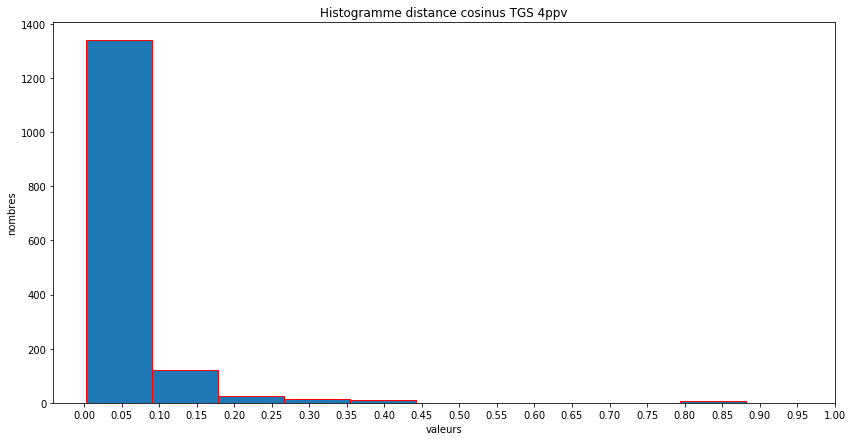

(array([   4,    5,    6, ..., 1485, 1486, 1487], dtype=int64),)


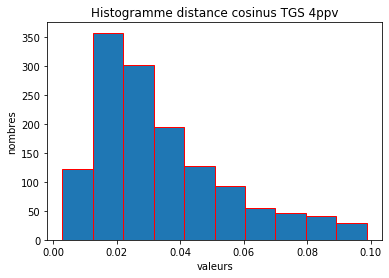

In [27]:
from sklearn.metrics.pairwise import cosine_distances
from scipy import stats

plt.figure(figsize=(14,7))

#print(stats.describe(embed_mat))
cosine_matrix = cosine_distances(embed_mat)
mb1 = [0,0.05,0.1,0.15,0.20,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1]
kppv_distance = np.empty([1520],dtype=float)
index=0
for row in cosine_matrix:
    t = np.array(row)
    indices = t.argsort()
    indices = indices[t[indices] > 0]
    kppv_distance[index] = t[indices[0]]
    index+=1
    kppv_distance[index] = t[indices[1]]
    index+=1
    kppv_distance[index] = t[indices[2]]
    index+=1
    kppv_distance[index] = t[indices[3]]
    index+=1
print(stats.describe(kppv_distance))
for val in kppv_distance:
    print(val)
plt.hist(kppv_distance,edgecolor = 'red')
plt.xlabel('valeurs')
plt.ylabel('nombres')
plt.xticks(mb1)
plt.title('Histogramme distance cosinus TGS 4ppv')
plt.show()


test = np.where(np.logical_and(kppv_distance>=0, kppv_distance<=0.1))
print(test)
arr = [len(test)]
ind = 0
for index in test:
    arr[ind] = kppv_distance[index]

plt.hist(arr,edgecolor = 'red')
plt.xlabel('valeurs')
plt.ylabel('nombres')
plt.xticks()
plt.title('Histogramme distance cosinus TGS 4ppv')
plt.show()

In [ ]:

sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 10)
def getCosineMatrix(emb):
    matrix = pairwise_distances(emb, metric='cosine', n_jobs=-1)
    return np.abs(matrix)
embed_mat, words = load_embeddings(os.path.join('datasets','TGSembeddings_w.csv'))
cosine_matrix = getCosineMatrix(embed_mat)

cosine_matrix2 = cosine_distances(embed_mat)
print(cosine_matrix2)
#print(cosine_matrix)
print(cosine_matrix.shape)

#tsne = TSNE(n_components=2,metric='precomputed',verbose=2,n_iter=2000,perplexity=15,early_exaggeration = 6)

listBatch = [20,30,40]
listPerplexity = [10,5,20]
listLearningRate = [12,6]
listEarlyExa = [10,20]
listTsne = []

'''for per in listPerplexity:
    tsne = TSNE(n_components=2,metric='precomputed',verbose=2,n_iter=2000,perplexity=per,learning_rate=500)
    listTsne.append(tsne)
    X_embedded = tsne.fit_transform(cosine_matrix)'''

'''for learnin in listLearningRate:
    tsne = TSNE(n_components=2,metric='precomputed',verbose=2,n_iter=2000,perplexity=15,learning_rate=learnin)
    listTsne.append(tsne)
    X_embedded = tsne.fit_transform(cosine_matrix)'''
'''for early in listEarlyExa:
    tsne = TSNE(n_components=2,metric='precomputed',verbose=2,n_iter=2000,perplexity=5,learning_rate=learnin)
    listTsne.append(tsne)
    X_embedded = tsne.fit_transform(cosine_matrix)'''

tsne = TSNE(n_components=2,metric='precomputed',verbose=2,n_iter=2000,perplexity=10,early_exaggeration = 12,learning_rate=10)
X_embedded = tsne.fit_transform(cosine_distances(embed_mat))
df_subset = {} 
df_subset['tsne-2d-one'] = X_embedded[:,0]
df_subset['tsne-2d-two'] = X_embedded[:,1]
plt.figure(figsize=(16,10))
p1 = sns.scatterplot(X_embedded[:,0], X_embedded[:,1], legend='full', palette=palette)
for line in range(0,embed_mat.shape[0]):
     p1.text(df_subset['tsne-2d-one'][line]+0.01, df_subset['tsne-2d-two'][line], 
     headerText[line], horizontalalignment='left', 
     size='small', color='black', weight='semibold')



In [ ]:
from sklearn.datasets import load_digits
X, y = load_digits(return_X_y=True)
print(X)
X.shape
y.shape


In [ ]:
from sklearn.manifold import MDS
embedding = MDS(n_components=2,verbose=1,dissimilarity='precomputed',n_init=10)
X_transformed = embedding.fit_transform(cosine_matrix)
print(X_transformed.shape)


df_subset2 = {} 
df_subset2['mds-2d-one'] = X_transformed[:,0]
df_subset2['mds-2d-two'] = X_transformed[:,1]
plt.figure(figsize=(16,10))
p2 = sns.scatterplot(X_transformed[:,0], X_transformed[:,1], legend='full', palette=palette)
for line in range(0,embed_mat.shape[0]):
     p2.text(df_subset2['mds-2d-one'][line]+0.01, df_subset2['mds-2d-two'][line], 
     headerText[line], horizontalalignment='left', 
     size='small', color='black', weight='semibold')


## Automatisation de GloVe puis t-sne pour test sur différrent taille de layer

Starting 0 GloVe model with emb_size = 10 batch size : 500
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 10)        3800        input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 10)        3800        input_2[0][0]                    
___________________________________

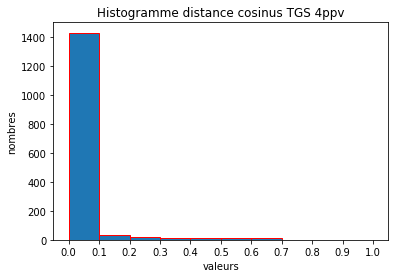

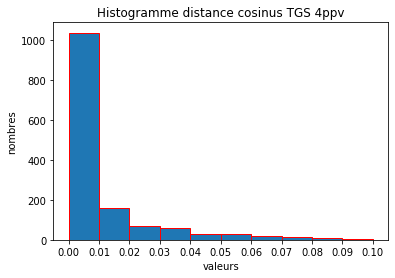

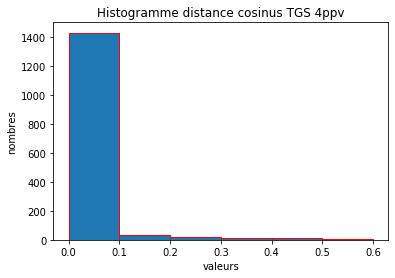

Duration: 0:02:35.262295
Starting [   0    4    5 ... 1511 1516 1517] GloVe model with emb_size = 10 batch size : 1250
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 10)        3800        input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 10)        3800        input_2[0

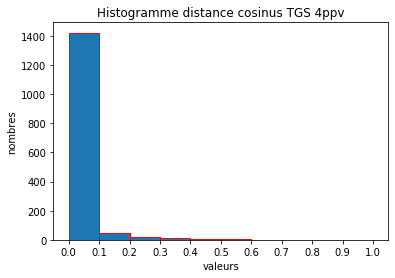

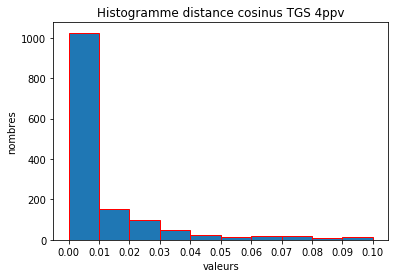

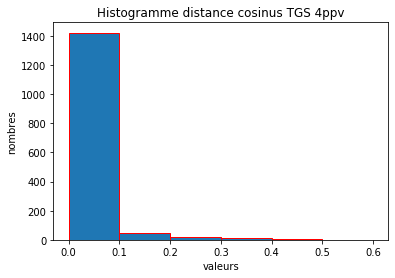

Duration: 0:02:44.916626
Starting [   0    1    2 ... 1517 1518 1519] GloVe model with emb_size = 10 batch size : 2500
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 10)        3800        input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 10)        3800        input_2[0

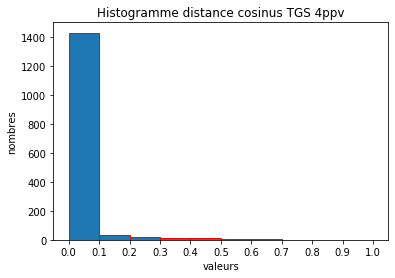

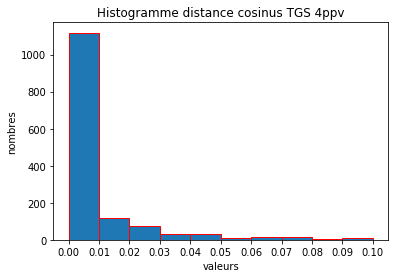

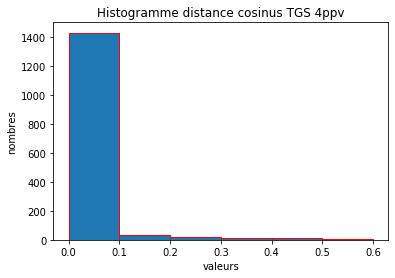

Duration: 0:02:32.262371
Starting [   0    1    2 ... 1516 1517 1518] GloVe model with emb_size = 20 batch size : 500
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 20)        7600        input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 20)        7600        input_2[0]

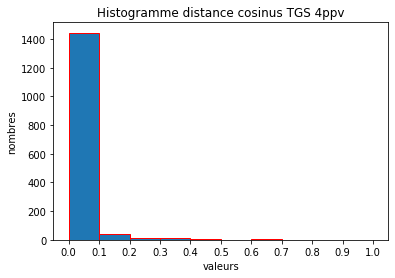

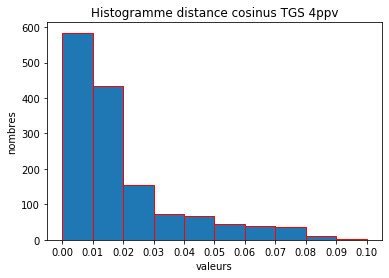

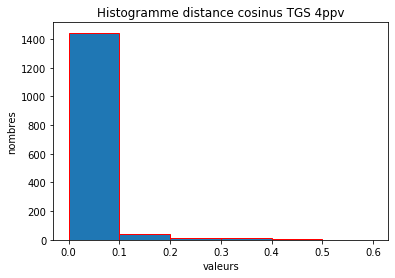

Duration: 0:02:31.733320
Starting [   0    1    2 ... 1517 1518 1519] GloVe model with emb_size = 20 batch size : 1250
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 20)        7600        input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 20)        7600        input_2[0

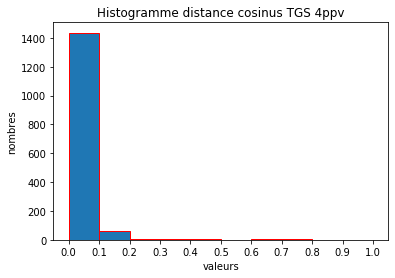

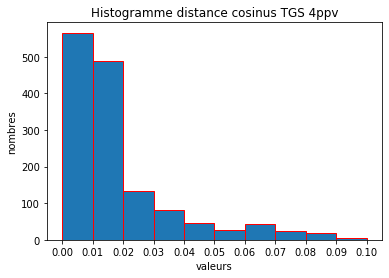

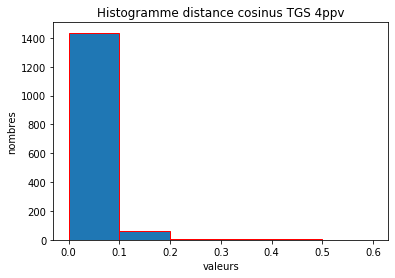

Duration: 0:02:40.393142
Starting [   4    5    6 ... 1517 1518 1519] GloVe model with emb_size = 20 batch size : 2500
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 20)        7600        input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 20)        7600        input_2[0

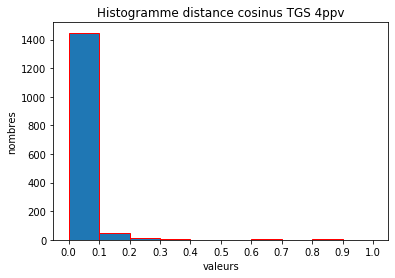

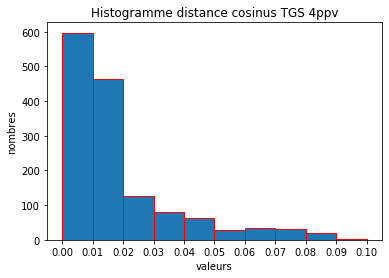

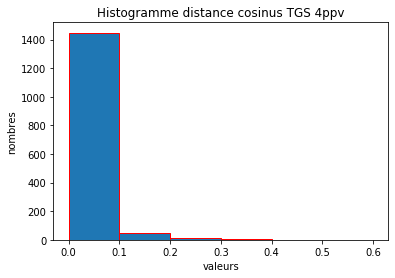

Duration: 0:02:51.085991
Starting [   0    4    5 ... 1517 1518 1519] GloVe model with emb_size = 30 batch size : 500
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 30)        11400       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 30)        11400       input_2[0]

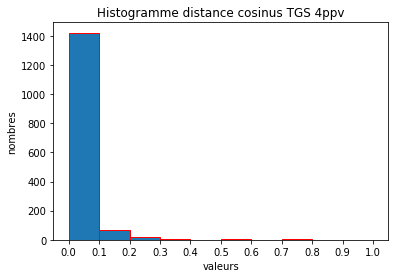

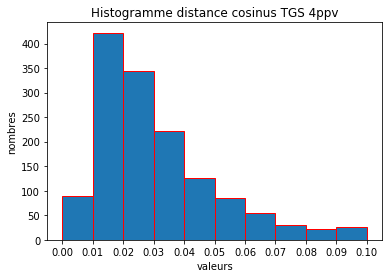

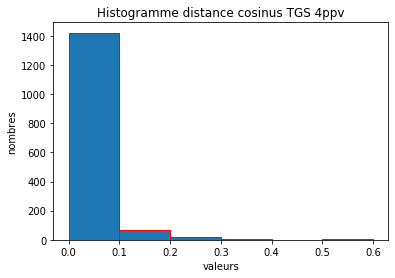

Duration: 0:02:50.758584
Starting [   4    5    6 ... 1517 1518 1519] GloVe model with emb_size = 30 batch size : 1250
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 30)        11400       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 30)        11400       input_2[0

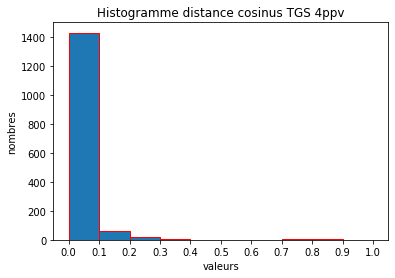

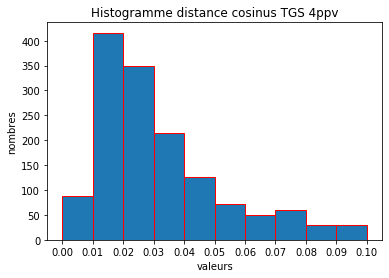

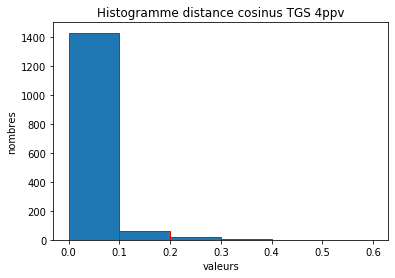

Duration: 0:02:42.863472
Starting [   4    5    6 ... 1517 1518 1519] GloVe model with emb_size = 30 batch size : 2500
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 30)        11400       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 30)        11400       input_2[0

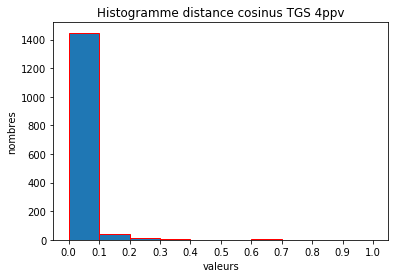

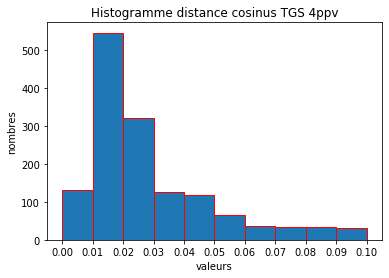

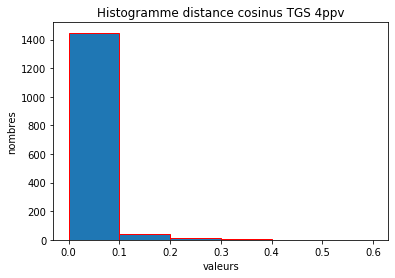

Duration: 0:02:34.674457
Starting [   4    5    6 ... 1517 1518 1519] GloVe model with emb_size = 40 batch size : 500
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 40)        15200       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 40)        15200       input_2[0]

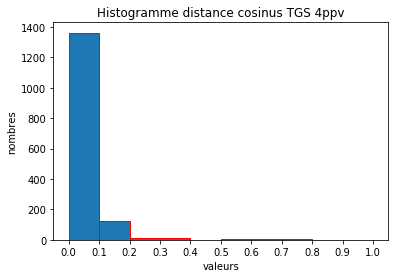

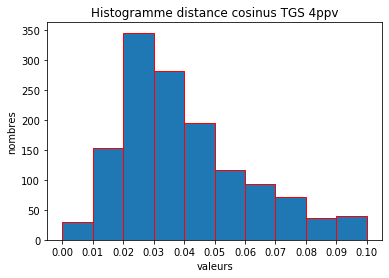

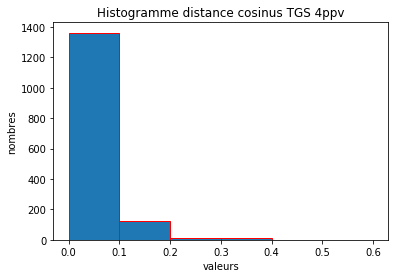

Duration: 0:02:34.519346
Starting [   4    5    6 ... 1517 1518 1519] GloVe model with emb_size = 40 batch size : 1250
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 40)        15200       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 40)        15200       input_2[0

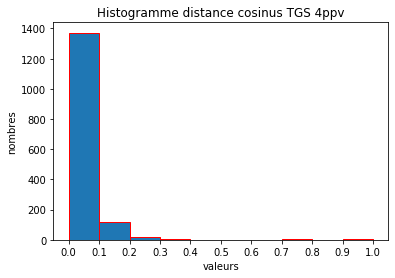

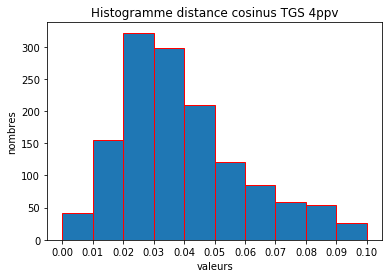

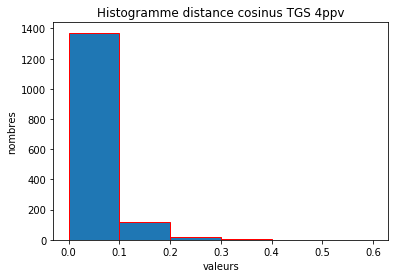

Duration: 0:02:40.832147
Starting [   4    5    6 ... 1517 1518 1519] GloVe model with emb_size = 40 batch size : 2500
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 40)        15200       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 40)        15200       input_2[0

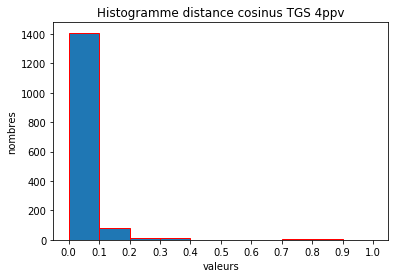

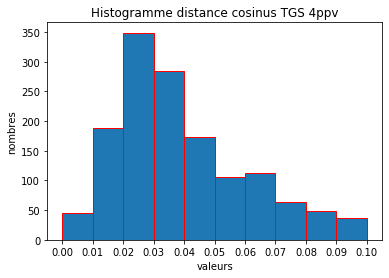

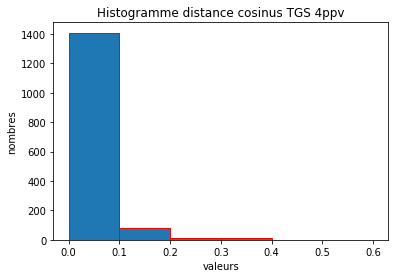

Duration: 0:02:42.103495
Starting [   4    5    6 ... 1517 1518 1519] GloVe model with emb_size = 50 batch size : 500
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 50)        19000       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        19000       input_2[0]

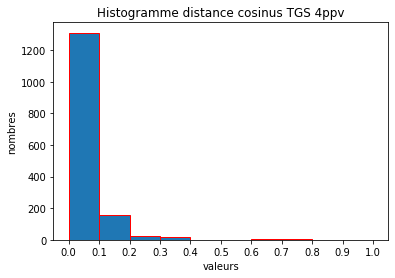

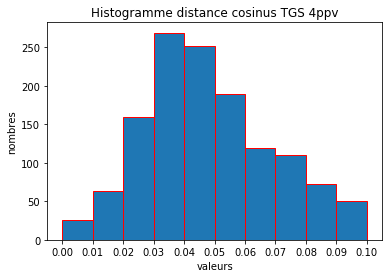

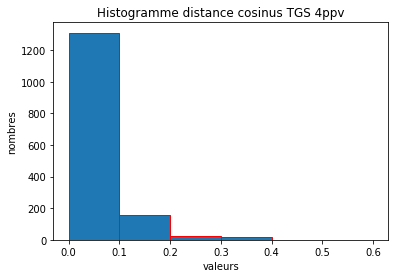

Duration: 0:02:35.608200
Starting [   4    5    6 ... 1517 1518 1519] GloVe model with emb_size = 50 batch size : 1250
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 50)        19000       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        19000       input_2[0

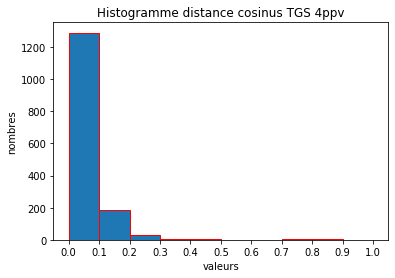

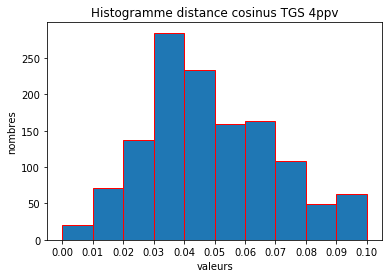

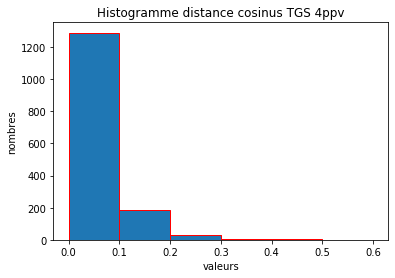

Duration: 0:02:39.232276
Starting [   4    5    6 ... 1517 1518 1519] GloVe model with emb_size = 50 batch size : 2500
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 50)        19000       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        19000       input_2[0

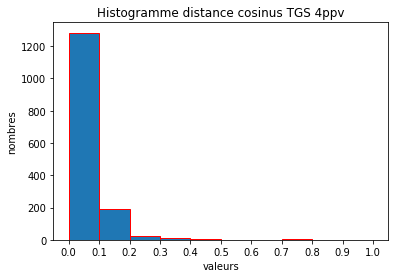

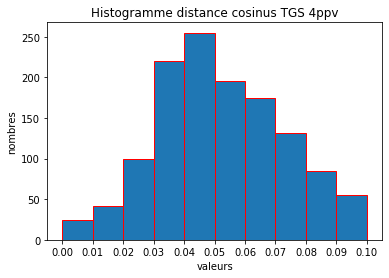

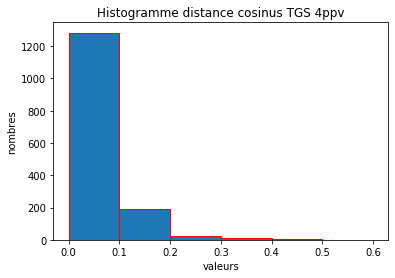

Duration: 0:02:41.568240
Starting [   4    5    6 ... 1517 1518 1519] GloVe model with emb_size = 60 batch size : 500
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 60)        22800       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 60)        22800       input_2[0]

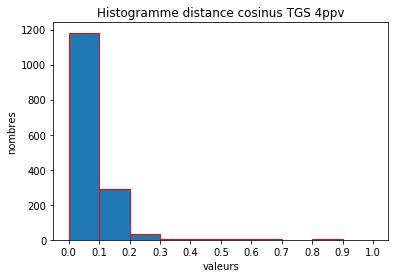

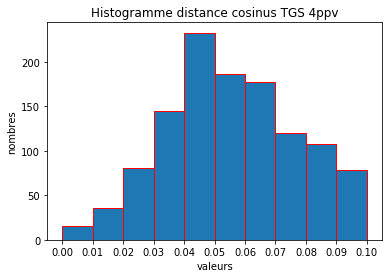

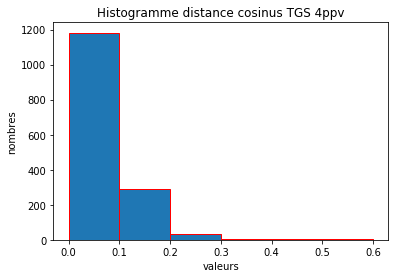

Duration: 0:02:55.529173
Starting [   4    5    6 ... 1517 1518 1519] GloVe model with emb_size = 60 batch size : 1250
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 60)        22800       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 60)        22800       input_2[0

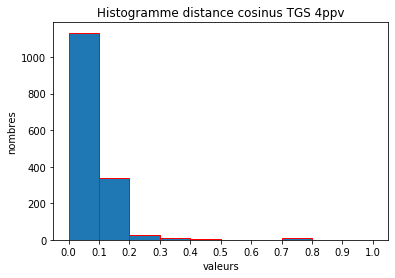

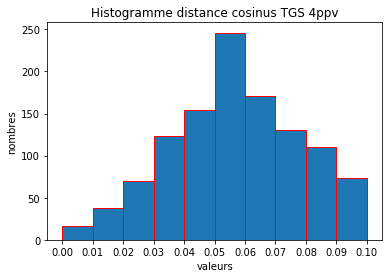

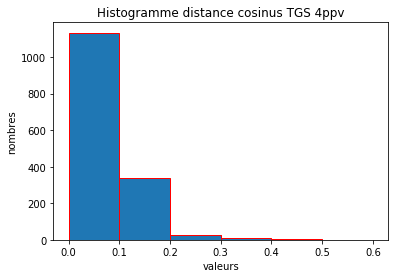

Duration: 0:02:54.381205
Starting [   4    5    6 ... 1517 1518 1519] GloVe model with emb_size = 60 batch size : 2500
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 60)        22800       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 60)        22800       input_2[0

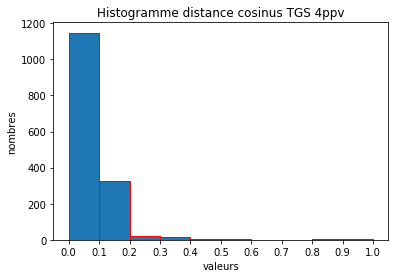

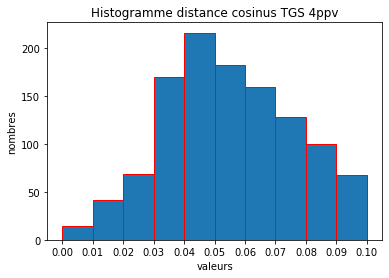

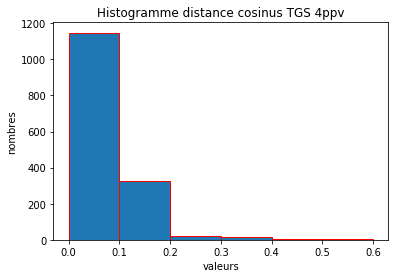

Duration: 0:02:57.881905


'listPerplexity = [10,5,20]\nlistLearningRate = [12,6]\nlistEarlyExa = [10,20]\n\n\nfor row in cooc_mat_cosine:\n    t = np.array(row)\n    indices = t.argsort()\n    indices = indices[t[indices] > 0]\n    print([t[indices[0]],t[indices[1]],t[indices[2]],t[indices[3]]])\nfor perp in listPerplexity:\n    for learn in listLearningRate:\n        for exa in listEarlyExa:\n            tsne = TSNE(n_components=2,metric=\'precomputed\',verbose=2,n_iter=2000,perplexity=perp,early_exaggeration = exa,learning_rate=learn)\n            X_embedded = tsne.fit_transform(cooc_mat_cosine)\n            df_subset = {} \n            df_subset[\'tsne-2d-one\'] = X_embedded[:,0]\n            df_subset[\'tsne-2d-two\'] = X_embedded[:,1]\n            plt.figure(figsize=(16,10))\n\n            p1 = sns.scatterplot(X_embedded[:,0], X_embedded[:,1], legend=\'full\', palette=palette)\n            index = 0\n            for line in range(0,Z.shape[0]):\n                if index%2 == 0:\n                    decalag

In [12]:
tf.compat.v1.disable_eager_execution()
from datetime import datetime
index = 0 
test_size = [10,20,30,40,50,60]
batch_size_test = [500,1250,2500]
for size in test_size:
    for batch_size_t in batch_size_test:
        start_time = datetime.now()
        print("Starting "+ str(index) +" GloVe model with emb_size = " + str(size) + " batch size : " + str(batch_size_t))
        K.clear_session()
        model = create_glove_model(v_size,size)
        model.summary()

        cooc_mat = load_npz(os.path.join('datasets','cooc_mat.npz'))
        print(cooc_mat.shape)
        batch_size = batch_size_t
        copy_docs = list(docs)
        index2word = dict(zip(tokenizer.word_index.values(), tokenizer.word_index.keys()))
        """ Each epoch """
        for ep in range(15):

            #valid_words = get_valid_words(docs, 20, tokenizer)

            random.shuffle(copy_docs)
            losses = []
            """ Each document (i.e. movie plot) """
            for doc in copy_docs:

                seq = tokenizer.texts_to_sequences([doc])[0]

                """ Getting skip-gram data """
                # Negative samples are automatically sampled by tf loss function
                wpairs, labels = skipgrams(
                    sequence=seq, vocabulary_size=v_size, negative_samples=0.0, shuffle=True
                )

                if len(wpairs)==0:
                    continue

                sg_in, sg_out = zip(*wpairs)
                sg_in, sg_out = np.array(sg_in).reshape(-1,1), np.array(sg_out).reshape(-1,1)
                x_ij = np.array(cooc_mat[sg_in[:,0], sg_out[:,0]]).reshape(-1,1) + 1

                assert np.all(np.array(labels)==1)
                assert x_ij.shape[0] == sg_in.shape[0], 'X_ij {} shape does not sg_in {}'.format(x_ij.shape, sg_in.shape)
                """ For each batch in the dataset """
                model.fit([sg_in, sg_out], x_ij, batch_size = batch_size, epochs=1, verbose=0)
                l = model.evaluate([sg_in, sg_out], x_ij, batch_size=batch_size, verbose=0)
                losses.append(l)
            print('Loss in epoch {}: {}'.format(ep, np.mean(losses)))



        save_embeddings(model, 'datasets', tokenizer, v_size)
        model.save('glove_model.h5')
        from sklearn.metrics.pairwise import cosine_distances
        from scipy import stats
        embed_mat, words = load_embeddings(os.path.join('datasets','TGSembeddings_w.csv'))
        #print(stats.describe(embed_mat))
        cosine_matrix = cosine_distances(embed_mat)
        mb1 = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
        mb2 = [0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1]
        mb3 = [0,0.1,0.2,0.3,0.4,0.5,0.6]
        kppv_distance = np.empty([1520],dtype=float)
        index=0
        for row in cosine_matrix:
            t = np.array(row)
            indices = t.argsort()
            indices = indices[t[indices] > 0]
            kppv_distance[index] = t[indices[0]]
            index+=1
            kppv_distance[index] = t[indices[1]]
            index+=1
            kppv_distance[index] = t[indices[2]]
            index+=1
            kppv_distance[index] = t[indices[3]]
            index+=1

        print(stats.describe(kppv_distance))
        plt.hist(kppv_distance,edgecolor = 'red',bins=mb1)
        plt.xlabel('valeurs')
        plt.ylabel('nombres')
        plt.xticks(mb1)
        plt.title('Histogramme distance cosinus TGS 4ppv')
        plt.show()


        test = np.where(np.logical_and(kppv_distance>=0, kppv_distance<=0.1))
        arr = [len(test)]
        ind = 0
        for index in test:
            arr[ind] = kppv_distance[index]

        plt.hist(arr,edgecolor = 'red',bins=mb2)
        plt.xlabel('valeurs')
        plt.ylabel('nombres')
        plt.xticks(mb2)
        plt.title('Histogramme distance cosinus TGS 4ppv')
        plt.show()
        
        test2 = np.where(np.logical_and(kppv_distance>=0, kppv_distance<=0.55))
        arr = [len(test2)]
        ind = 0
        for index in test2:
            arr[ind] = kppv_distance[index]

        plt.hist(arr,edgecolor = 'red',bins=mb3)
        plt.xlabel('valeurs')
        plt.ylabel('nombres')
        plt.xticks(mb3)
        plt.title('Histogramme distance cosinus TGS 4ppv')
        plt.show()
        end_time = datetime.now()
        print('Duration: {}'.format(end_time - start_time))
    
'''listPerplexity = [10,5,20]
listLearningRate = [12,6]
listEarlyExa = [10,20]


for row in cooc_mat_cosine:
    t = np.array(row)
    indices = t.argsort()
    indices = indices[t[indices] > 0]
    print([t[indices[0]],t[indices[1]],t[indices[2]],t[indices[3]]])
for perp in listPerplexity:
    for learn in listLearningRate:
        for exa in listEarlyExa:
            tsne = TSNE(n_components=2,metric='precomputed',verbose=2,n_iter=2000,perplexity=perp,early_exaggeration = exa,learning_rate=learn)
            X_embedded = tsne.fit_transform(cooc_mat_cosine)
            df_subset = {} 
            df_subset['tsne-2d-one'] = X_embedded[:,0]
            df_subset['tsne-2d-two'] = X_embedded[:,1]
            plt.figure(figsize=(16,10))

            p1 = sns.scatterplot(X_embedded[:,0], X_embedded[:,1], legend='full', palette=palette)
            index = 0
            for line in range(0,Z.shape[0]):
                if index%2 == 0:
                    decalage = 0.03
                else:
                    decalage = -0.03
                p1.text(df_subset['tsne-2d-one'][line]+decalage, df_subset['tsne-2d-two'][line]+decalage, 
                 headerText[line], horizontalalignment='left', 
                 size='small', color='black', weight='semibold')
                index+=1
            p1.figure.savefig("Visualisation/Oniris_RAW_TSNE/"+str(perp)+"_"+str(exa)+"_"+str(learn))    
'''

In [45]:
import fasttext
from fasttext import train_unsupervised

myfile = open('fasttext.txt', 'w', encoding='utf-8')
for sentence in docs:
    myfile.write('1,"'+sentence+'"')
myfile.close()


In [49]:

print("-----------------Generating SkipGram model with FastText-----------------")
model = fasttext.train_unsupervised('D:\\Documents\\Polytech\\fastextt.
                                    ', model='skipgram')
model.save_model("./fastTextSkipGram.bin")
print("-----------------Generating CBOW model with FastText-----------------")
model = fasttext.train_unsupervised('./fastext.txt', model='cbow')
model.save_model("./fastTextCBOW.bin")

-----------------Generating SkipGram model with FastText-----------------


ValueError: D:\Documents\Polytech\ttttyt cannot be opened for training!

In [35]:
import os
myfile = open('fasttext.txt', 'w', encoding='utf-8')
print(myfile)
myfile.close()
print(myfile)
path = "D:\Documents\Polytech"
print(os.path.join(path, "fastext.txt")) 

<_io.TextIOWrapper name='fasttext.txt' mode='w' encoding='utf-8'>
<_io.TextIOWrapper name='fasttext.txt' mode='w' encoding='utf-8'>
D:\Documents\Polytech\fastext.txt
